In [15]:
a = 6598. - 6532.
b = 6598. - 6506.

print(a/b)



0.717391304347826


In [16]:
a_ = 3384. - 3285.
b_ = 3384. - 3243.

print(a_/b_)

0.7021276595744681


# Diagnosis Tests for Wavelength Calibration

In [173]:
# imports
from ccdproc import CCDData
import matplotlib.pyplot as plt
from astropy import units as u
import numpy as np
from scipy import signal
from math import factorial
from itertools import combinations

# change default size image
plt.rcParams["figure.figsize"] = [16,9]
# files
lamp_600Mid_Ne = 'fits/cfzsto_0199_goodman_comp_600Mid_GG385_Ne.fits'
lamp_400M2_HgArNe = 'fits/0170_goodman_comp_400M2_GG455_HgArNe_Domelights_OFF.fits'

## 600Mid - Ne

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[3049, 3079, 3241, 3282, 3384, 3508, 3568, 3901, 4049]


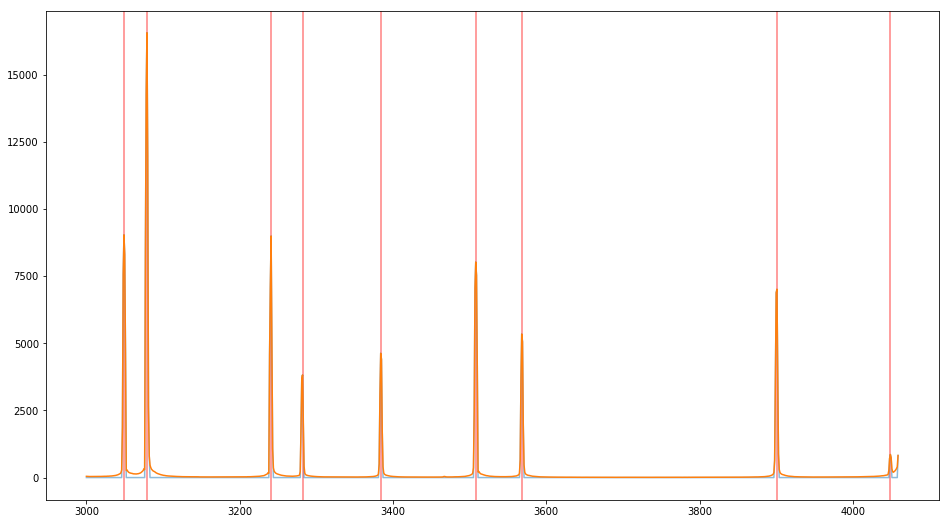

In [174]:
# read files
ccd_6 = CCDData.read(lamp_600Mid_Ne, unit=u.adu)
spatial_dim, dispersion_dim = ccd_6.data.shape

low_lim = int(spatial_dim / 2.) - 10
hig_lim = int(spatial_dim / 2.) + 10

spectrum = np.median(ccd_6.data[low_lim:hig_lim,:], axis=0)
x_axis = range(len(spectrum))

sub_x_axis = x_axis[3000:]
sub_spectrum = spectrum[3000:]
sub_spectrum = np.nan_to_num(sub_spectrum)
# print(dir(sub_spectrum))

# Line identification 
filtered_data = np.where(
    np.abs(sub_spectrum > sub_spectrum.min() + 0.03 * sub_spectrum.max()),
    sub_spectrum,
    None)

none_to_num = [0 if it is None else it for it in filtered_data]
filtered_data = np.array(none_to_num)
peaks = signal.argrelmax(filtered_data, axis=0, order=7)[0]
# print(peaks)

pixel_peaks = [sub_x_axis[peak] for peak in peaks]
print(pixel_peaks)
# angstrom_peaks = [6382.991,
#                   6402.248,
#                   6506.138,
#                   6532.882,
#                   6598.953,
#                   6678.277,
#                   -6717.043,
#                   6929.467,
#                   7032.844]
angstrom_peaks = [6382.991,
                  6402.248,
                  6506.138,
                  6532.882,
                  6598.953,
                  6678.277,
                  6117.043,
                  6929.467,
                  7032.844]
line_elements = ['Ne I',
                 'Ne I',
                 'Ar II',
                 'Ne I',
                 'Ne I',
                 'Ne I',
                 'Ne I',
                 'Ne I',
                 ' -- ']
for peak in peaks:
     plt.axvline(sub_x_axis[peak], color='r', alpha=0.5)
plt.plot(sub_x_axis, filtered_data, alpha=0.5)
plt.plot(sub_x_axis, sub_spectrum)

plt.show()

In [215]:
# angstrom_peaks = [-6382.991,
#                   -6402.248,
#                   6506.138,
#                   6532.882,
#                   6598.953,
#                   6678.277,
#                   6717.043,
#                   6929.467,
#                   -7032.844]
angstrom_peaks = [6982.991,
                  5402.248,
                  6506.138,
                  6532.882,
                  6598.953,
                  6678.277,
                  6717.043,
                  6929.467,
                  7932.844]

def get_ratio(pixels, angstrom, limits):
    
    for i in combinations(limits, 3):
        print(i)
        a_pix = pixels[i[1]] - pixels[i[0]]
        a_angs = angstrom[i[1]] - angstrom[i[0]]   
        b_pix = pixels[i[2]] - pixels[i[0]]
        b_angs = angstrom[i[2]] - angstrom[i[0]]
            
        ratio = [a_pix / b_pix, a_angs / b_angs, i]
        print(":: {:d}-{:d}/{:d}-{:d} :: "
              " :: {:f} {:f}".format(i[1], 
                                                i[0],
                                                i[2],
                                                i[0], 
                                                ratio[0],
                                                ratio[1]))
        yield ratio


def get_mismatch(failing_list):
    bad_lines = []
    for failing in failing_list:
        if failing[0] not in bad_lines:
            bad_lines.append(failing[0])
    return bad_lines
#     print(failing_list)
#     mismatch = list(set(failing_list[0]).intersection(*failing_list))
#     print("Mismatch ", mismatch)
#     if len(mismatch) == 1:
#         return mismatch[0]
#     elif len(mismatch) > 1:
#         return np.min(mismatch)
    
# 
def check_ratios(pixel_list, angstrom_list, n_check=3, threshold=0.1):
    assert len(pixel_list) == len(angstrom_list)
    pixel_ratios = []
    angstrom_ratios = []
    _negatives = []
    mismatching_lines = []
    number_of_checks = int(factorial(n_check + 1) / (2 * factorial(n_check - 1)))
    for comb in combinations(range(number_of_checks), 3):
        print("COMB ", comb)
    
    ratio_generator = get_ratio(pixel_list, angstrom_list, range(n_check))
    for ratio in ratio_generator:
        
        _valid = abs(ratio[0] - ratio[1]) < threshold
            
        if not _valid:
            print("Not valid")
            _negatives.append(ratio[2])
            print(ratio[2])
#         if ((_valid and _negatives != [])):
#             bad = get_mismatch(_negatives)
#             print('Bad ', bad)
#             mismatching_lines.append(bad)
#             _negatives = []
        
    if _negatives != []:
        mismatching_lines = get_mismatch(_negatives)
    print(" ")
    return mismatching_lines

bad_lines = check_ratios(pixel_peaks, angstrom_peaks)

if len(bad_lines) == 0:
    print("There are no mismatching lines! ")
else:
    for line in bad_lines:
        print(r"{:d} {:.3f} px - {:.3f} A is a bad match".format(line, pixel_peaks[line], angstrom_peaks[line]))

COMB  (0, 1, 2)
COMB  (0, 1, 3)
COMB  (0, 1, 4)
COMB  (0, 1, 5)
COMB  (0, 2, 3)
COMB  (0, 2, 4)
COMB  (0, 2, 5)
COMB  (0, 3, 4)
COMB  (0, 3, 5)
COMB  (0, 4, 5)
COMB  (1, 2, 3)
COMB  (1, 2, 4)
COMB  (1, 2, 5)
COMB  (1, 3, 4)
COMB  (1, 3, 5)
COMB  (1, 4, 5)
COMB  (2, 3, 4)
COMB  (2, 3, 5)
COMB  (2, 4, 5)
COMB  (3, 4, 5)
(0, 1, 2)
:: 1-0/2-0 ::  :: 0.156250 3.314948
Not valid
(0, 1, 2)
 
0 3049.000 px - 6982.991 A is a bad match


## How to identify the bad ones?